In [1]:
import tensorflow as tf
import random
import os
import sys
import numpy as np
import torch
import logging
import argparse
import shutil
import cv2
import time
import threading
import multiprocessing
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
from icecream import ic
from collections import defaultdict
import re

2022-02-16 01:29:09.595048: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [88]:
pwd

'/home/ai-046/Notebook/tensorflow_developer'

In [89]:
import uuid

In [90]:
for i in range(10):
    print(uuid.uuid1())

5cdb24c6-8593-11ec-8f43-3cecefb49cd0
5cdb27c3-8593-11ec-9f71-3cecefb49cd0
5cdb322b-8593-11ec-830b-3cecefb49cd0
5cdb333d-8593-11ec-900c-3cecefb49cd0
5cdb342b-8593-11ec-bb8a-3cecefb49cd0
5cdb34f2-8593-11ec-a5e9-3cecefb49cd0
5cdb35b9-8593-11ec-ba46-3cecefb49cd0
5cdb3690-8593-11ec-b3d4-3cecefb49cd0
5cdb3756-8593-11ec-ab9f-3cecefb49cd0
5cdb3821-8593-11ec-bd38-3cecefb49cd0


In [91]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [92]:
DATA_DIR = Path('/home/ai-046/X/tensorflow_test/data')
POSSRC_PATH = DATA_DIR / 'positive_src'
POS_PATH = DATA_DIR / 'positive'
NEG_PATH = DATA_DIR / 'negtive'
ANC_PATH = DATA_DIR / 'anchor'
POSSRC_PATH.mkdir(parents=True, exist_ok=True)
NEG_PATH.mkdir(parents=True, exist_ok=True)
ANC_PATH.mkdir(parents=True, exist_ok=True)
lfw_dir = Path("/home/ai-046/X/Datasets/lfw")

In [93]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1, 2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1, 3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100), np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100,
                                                     seed=(np.random.randint(100), np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1,
                                                   seed=(np.random.randint(100), np.random.randint(100)))
        data.append(img)
    return data

ic| augment_img[0].numpy().shape: (250, 250, 3)


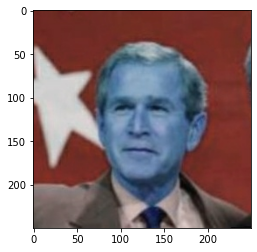

In [94]:
imgpath = "./Sources/George_W_Bush_0001.jpg"
img = cv2.imread(imgpath)
augment_img = data_aug(img)
# plt.imshow(img)
# ic(type(augment_img[0]))

# ic(dir(augment_img[0]))
ic(augment_img[0].numpy().shape)
# ic(augment_img[0])
plt.imshow(augment_img[0])

In [95]:
if 0:
    tempdir = Path("/home/ai-046/X/tensorflow_test/data/positive")
    tempdir.mkdir(exist_ok=True)
    for i, imgfile in enumerate(POSSRC_PATH.iterdir()):
        img = cv2.imread(str(imgfile))
        if img is None:continue
        augment_imgs = data_aug(img)
        imgdir = imgfile.parent
        for j, subimg in enumerate(augment_imgs):
            newimgfile = tempdir/f"augment_{uuid.uuid1()}.jpg"
            cv2.imwrite(str(newimgfile), subimg.numpy())


## 加载预处理图片

### 获取图片目录

In [96]:
anchor = tf.data.Dataset.list_files(str(ANC_PATH/"*.jpg")).take(300)
negtive = tf.data.Dataset.list_files(str(NEG_PATH/"*.jpg")).take(300)
positive = tf.data.Dataset.list_files(str(POS_PATH/"*.jpg")).take(300)
                                    

In [97]:
negtive

<TakeDataset shapes: (), types: tf.string>

In [98]:
dir_test = anchor.as_numpy_iterator()

In [99]:
dir_test.next()

b'/home/ai-046/X/tensorflow_test/data/anchor/George_W_Bush_0205.jpg'

### 预处理

In [100]:
def preprocess(img_path):
    byte_img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img 
imgpath = "./Sources/George_W_Bush_0001.jpg"
img = preprocess(imgpath)
ic(img.shape)
ic(type(img))
# ic(img)

ic| img.shape: TensorShape([100, 100, 3])
ic| type(img): <class 'tensorflow.python.framework.ops.EagerTensor'>


tensorflow.python.framework.ops.EagerTensor

### 创建带有标签的数据集

In [101]:
len(anchor)

300

In [116]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negtives = tf.data.Dataset.zip((anchor, negtive, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negtives)

In [103]:
data
len(positives)
len(negtives)
len(data)

600

In [104]:
samples = data.as_numpy_iterator()

In [105]:
example = samples.next()

In [106]:
example

(b'/home/ai-046/X/tensorflow_test/data/anchor/George_W_Bush_0026.jpg',
 b'/home/ai-046/X/tensorflow_test/data/positive/augment_aadd7ea8-8592-11ec-8fde-3cecefb49cd0.jpg',
 1.0)

In [107]:
imgpath1 = Path("/home/ai-046/X/tensorflow_test/data/positive/augment_9e3899cc-8592-11ec-9f46-3cecefb49cd0.jpg")
img1=cv2.imread(str(imgpath1))
img1.shape

(250, 250, 3)

In [108]:
preprocess("/home/ai-046/X/tensorflow_test/data/positive/augment_9e3899cc-8592-11ec-9f46-3cecefb49cd0.jpg")

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.05490196, 0.03137255, 0.00294118],
        [0.18627451, 0.11862745, 0.04019608],
        [0.19117647, 0.1254902 , 0.05      ],
        ...,
        [0.1879902 , 0.11544117, 0.04779412],
        [0.18431373, 0.12352941, 0.05      ],
        [0.1754902 , 0.1245098 , 0.05      ]],

       [[0.05490196, 0.03137255, 0.00294118],
        [0.18627451, 0.11862745, 0.04019608],
        [0.19117647, 0.1254902 , 0.05      ],
        ...,
        [0.1875    , 0.11446078, 0.04705882],
        [0.1879902 , 0.12132353, 0.05073529],
        [0.18921569, 0.12843138, 0.05490196]],

       [[0.05490196, 0.03137255, 0.00294118],
        [0.18627451, 0.11862745, 0.04019608],
        [0.19117647, 0.1254902 , 0.05      ],
        ...,
        [0.18529412, 0.11078431, 0.04411765],
        [0.1882353 , 0.11519608, 0.04779412],
        [0.19607843, 0.12352941, 0.05588235]],

       ...,

       [[0.01127451, 0.01764706, 0.01446078],
        [0.21

In [109]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [110]:
res = preprocess_twin(*example)

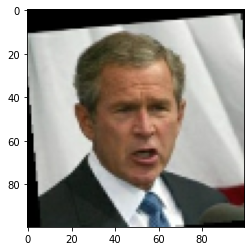

In [112]:
plt.imshow(res[0])

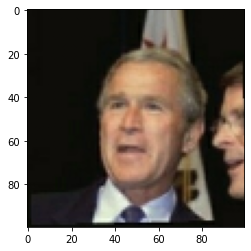

In [113]:
plt.imshow(res[1])

In [114]:
res[2]

1.0

In [117]:
data_ = data.map(preprocess_twin)
data_ = data_.cache().shuffle(buffer_size=10000)

In [120]:
train_data = data_.take(round(len(data_)*.7))
train_data = train_data.batch(4)
train_data = train_data.prefetch(2)

In [121]:
# test_data = data_.take(round(len(data_)*.7))
test_data = data_.skip(round(len(data_)*.7))
test_data = test_data.batch(4)
test_data = test_data.prefetch(2)

In [122]:
test_data

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [124]:
len(test_data), len(train_data)

(45, 105)

### 构建模型

In [126]:
def make_embeding():
    inp = tf.keras.layers.Input(shape=(100,100,3), name='input_image')
    c1 = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inp)
    m1 = tf.keras.layers.MaxPooling2D()(c1)
    c2 = tf.keras.layers.Conv2D(64, (5,5), activation='relu')(m1)
    m2 = tf.keras.layers.MaxPooling2D()(c2)
    c3 = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(m2)
    m3 = tf.keras.layers.MaxPooling2D()(c3)
    c4 = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(m3)
    f1 = tf.keras.layers.Flatten()(c4)
    d1 = tf.keras.layers.Dense(2048, activation='sigmoid')(f1)
    return tf.keras.Model(inputs=[inp], outputs=[d1], name='embeding')

In [128]:
embdeing = make_embeding()
embdeing.summary()

Model: "embeding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 128)       0  

### 构建距离层

In [129]:
class L1Distance(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__()
    def call(self, input_embeding, validation_embeding):
        return tf.math.abs(input_embeding - validation_embeding)

In [130]:
l1 = L1Distance()

### 构建整体的孪生网络

In [132]:
def make_siamese_model():
    input_image = tf.keras.layers.Input(name='input_image', shape=(100, 100, 3))
    validation_image = tf.keras.layers.Input(name='validation_image', shape=(100, 100, 3))
    embdeing = make_embeding()
    simaese_layer = L1Distance()
    simaese_layer._name = "distance"
    distances = simaese_layer(embdeing(input_image), embdeing(validation_image))
    classifier = tf.keras.layers.Dense(1, activation='sigmoid')(distances)
    return tf.keras.Model(
        inputs=[input_image, validation_image],
        outputs=[classifier], 
        name='SiameseNetwork'
    )

In [133]:
siamese_model = make_siamese_model()

In [134]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_image (InputLayer)   [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embeding (Functional)           (None, 2048)         33977664    input_image[0][0]                
                                                                 validation_image[0][0]           
__________________________________________________________________________________________________
distance (L1Distance)           (None, 2048)         0           embeding[0][0]      

### 训练

In [136]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [137]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

### 自定义train step

In [145]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
        grad = tape.gradient(loss, siamese_model.trainable_variables)
        opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

### 定义训练的循环

In [139]:
from tensorflow.keras.metrics import Recall, Precision

In [148]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print(f"\n{epoch}/{EPOCHS} ")
        progbar = tf.keras.utils.Progbar(len(data))
        r = Recall()
        p = Precision()
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(f"{loss.numpy()}, {r.result().numpy()}, {p.result().numpy()}")
        

### 训练

In [149]:
train(train_data,4)


1/4 
105/105 [==============================] - 7s 62ms/step
0.4830748736858368, 0.606796145439148, 0.7102272510528564

2/4 
105/105 [==============================] - 6s 61ms/step
0.18760770559310913, 0.7281106114387512, 0.7745097875595093

3/4 
105/105 [==============================] - 6s 61ms/step
0.749052107334137, 0.711442768573761, 0.8614457845687866

4/4 
105/105 [==============================] - 6s 61ms/step
0.13236358761787415, 0.8037382960319519, 0.9005235433578491
